# Projet : Black Jack

### Description: 

Dans ce projet nous allons tenter d'appliquer les algortithmes de reinforcement appris en cours sur le jeu du Black Jack.

### Régles:
Avant tout faisons un point sur les règles de ce jeu : Le jeu commence avec deux cartes distribuées au croupier et au joueur. L'une des cartes du croupier est face visible et l'autre est face cachée. Si le joueur a 21 immédiatement (un as et un 10), on dit qu'il a un "Black Jack". Il gagne, sauf si le croupier a également un "Black Jack", auquel cas le jeu est nul (il y a égalité.). Si le joueur n'a pas de "Black Jack", il peut demander des cartes supplémentaires, une par une (hits), jusqu'à ce qu'il s'arrête (sticks) ou dépasse 21 (go bust). S'il dépasse 21, il perd ; s'il reste, c'est le tour du croupier. Le croupier demande des cartes supplémentaires ou s'arrête selon une stratégie fixe sans choix : il s'arrête sur toute somme de 17 ou plus, et demande un carte autrement. Si le croupier dépasse 21, le joueur gagne ; sinon, le résultat (victoire, défaite ou match nul) est déterminé par la somme finale qui est la plus proche de 21. Si le joueur détient un as il pourrait le compter comme 11.


Avant d'implémenter l'algorithme il faut que nous definissions le cadre dans lequel nous allons travailler. Nous avons 3 éléments:
- le state
- les actions
- les rewards

## Le state:
3 informations seront contenus dans le state:
- la valeur des cartes du joueur
- la valeur de la carte du croupier
- la présence d'un as utilisable dans les cartes du joueur

Le state sera donc un array de longueurs 3 avec ces trois informations

## Les actions:
2 actions sont possibles a chaque tour:
- S'arreter
- Demander une carte

On representera donc l'action "s'arreter" par 0 et l'action "demander une carte" par 1.

## Les rewards:
Il y a trois issues possible une partie: victoire, match nul, defaite. On définit donc respectivement les rewards 1,0,-1.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

Avant d'implémenter l'environnement on implmente 3 fonctions qui nous seront utiles:
- giveCard() qui tire une carte au hasard
- dealerPolicy qui à partir de la valeur des cartes du croupier calcul la valeur de ses cartes à l'étape suivante en appliquant la policy du croupier (définie précédemment)
- getRewardFromDealer cette fonction sera appellée apres que le joueur a fini du jouer. Elle fait jouer le croupier et renvoie la reward de la partie (-1, 0 ou 1) en fonction de ce qu'a joué le croupier.

In [2]:
def giveCard():
    # 1 stands for ace
    c_list = list(range(1, 11)) + [10, 10, 10]
    return np.random.choice(c_list)

def dealerPolicy(current_value, usable_ace, is_end):
    if current_value > 21:
        if usable_ace:
            current_value -= 10
            usable_ace = False
        else:
            return current_value, usable_ace, True
    # HIT17
    if current_value >= 17:
        return current_value, usable_ace, True
    else:
        card = giveCard()
        if card == 1:
            if current_value <= 10:
                return current_value + 11, True, False
            return current_value + 1, usable_ace, False
        else:
            return current_value + card, usable_ace, False
        
        
def getRewardFromDealer(dealerValue,playerValue):
    if dealerValue==1:
        usable_ace=True
    else:
        usable_ace=False
    is_end=False
    while not is_end:
        dealerValue, usable_ace, is_end=dealerPolicy(dealerValue, usable_ace, is_end)
    if playerValue>21:
        if dealerValue>21:
            return 0
        return -1
    else:
        if dealerValue > 21:
            return 1
        else:
            if dealerValue>playerValue:
                return -1
            elif dealerValue<playerValue:
                return 1
            return 0

On implément ensuite l'environnement de jeu qui comprned plusiers méthodes:
- reset() qui initialise une partie en tirant un carte pour le croupier et 2 pour le joueur
- step(action) qui va effectuer l'action demandée et renvoyer le nouvel état de l'environnement, la reward associée et si le jeu est fini (done= True ou False)
- getState() renvoie l'état dans lequel se trouve l'environnement

In [3]:
# Environment and rules
class BlackJackEnv():
    def __init__(self):
        self.reset()

    def step(self, action):
        assert action==0 or action==1
        
        if action == 0:#si on s'arrete on va faire jouer le dealer ( getRewardFromDealer) et on note la reward
            done=True
            reward=getRewardFromDealer(self.dealerValue,self.playerValue)
            
        else:#action=1 on demande une carte
            card=giveCard()
            if card==1: #si la carte est un 1
                if self.playerValue<=10: # en dessous de 10 on garde l'as à la valeur 1 et on a un as utlisable
                    self.playerValue+=11
                    self.usableAce=True
                    reward=0
                    done=False
                else: # sinon on prend l'as à 1 
                    self.playerValue+=1
                    reward=0
                    done=False
            else: # si ce n'est pas un as 
                self.playerValue+=card # on ajoute la valeur de la carte à notre compte actuel
                if self.playerValue>21: 
                    # si on dépasse 21 le jeu est fini on fait jouer le dealer pour connaitre la reward
                    # sauf si on a un as utilisable
                    if self.usableAce:
                        self.playerValue-=10
                        done=False
                        reward=0
                        self.usableAce=False
                    else: # sinon on va 
                        reward=getRewardFromDealer(self.dealerValue,self.playerValue)
                        done=True
                else:# si on ne dépasse pas 21 on continue
                    reward=0
                    done=False
            
                
        return self.get_state(),reward, done, {}
    

    def get_state(self):
        return (self.playerValue,self.dealerValue,self.usableAce)
    
    def reset(self):#initialisation du jeu on tire 2 carte pour le jouer et 1 pour le dealer 
        firstCardPlayer=giveCard()
        secondCardPlayer=giveCard()
        if firstCardPlayer==1 and secondCardPlayer==1:
            self.usableAce=True
            self.playerValue=12
        elif firstCardPlayer==1 or secondCardPlayer==1:
            self.usableAce=True
            self.playerValue=firstCardPlayer+secondCardPlayer+10
        else:
            self.usableAce=False
            self.playerValue=firstCardPlayer+secondCardPlayer
        self.dealerValue=giveCard()
        return self.get_state()

## Jeu aléatoire

In [4]:
env = BlackJackEnv()

In [5]:
#Politica Random:
victory=0
defeat=0
nul=0
for i_episode in range(10000):
    state = env.reset()
    while True:
        action = np.random.choice([0,1]) # Selects a random action 
        state, reward, done, info = env.step(action) # Plays one round
        if done:
            break
    if reward==1:
        victory+=1
    elif reward==0:
        nul+=1
    elif reward==-1:
        defeat+=1
print('Pourcentage de victoire',victory/100)
print('Pourcentage de défaite',defeat/100)
print("Pourcentage d'égalité",nul/100)

Pourcentage de victoire 29.07
Pourcentage de défaite 57.31
Pourcentage d'égalité 13.62


## Graphique:

Nous implémentons 2 fonctions qui nous permettrons de comparer les différents algorithmes:
- plot_values qui tracera un graphique 3d pour visualiser la value fonction
- plot_policy pour visualiser la policy 

In [6]:
#useless pour l'instant
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_values(V,aceUsable):
    """
    Does a 3D display of the value function.
        
    The parameter V describes the value function in function of the number of "heads in your hand"
    and "actual bet".
    """
    def get_Z(x, y):
        if (x,y,aceUsable) in V:
            return V[x,y,aceUsable]
        else:
            return 0

    def get_figure(ax):
        x_range = np.arange(0, 22)
        y_range = np.arange(0, 11)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Cartes du joueur')
        ax.set_ylabel('Carte du croupier')
        ax.set_zlabel('value')
        ax.view_init(ax.elev, -120)
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    get_figure(ax)
    plt.show()

In [7]:
def plot_policy(policy):
    dataTrue=np.zeros((21,10))
    for i in range(1,22):
        for j in range(1,11):
            if(i,j,True) in policy:
                dataTrue[i-1][j-1]=policy[(i,j,True)]+1
    dataFalse=np.zeros((21,10))
    for i in range(1,22):
        for j in range(1,11):
            if(i,j,False) in policy:
                dataFalse[i-1][j-1]=policy[(i,j,False)]+1
    plt.subplot(121)
    plt.imshow(dataTrue, cmap=plt.cm.BuPu_r)
    plt.title("Avec as utilisable")
    plt.xlabel('Carte du croupier')
    plt.ylabel('Carte du joueur')
    plt.subplot(122)
    plt.imshow(dataFalse, cmap=plt.cm.BuPu_r)
    plt.title("Sans as utilisable")
    plt.xlabel('Carte du croupier')
    plt.ylabel('Carte du joueur')
    plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    cax = plt.axes([0.85, 0.1, 0.075, 0.8])
    plt.colorbar(cax=cax)
    plt.show()

In [8]:
def playGames(numberGames,policy):
    victory=0
    defeat=0
    nul=0
    for i in range(numberGames):
        state=env.reset()
        episode=[]
        done=False
        while not done:
            if state in policy:
                action=policy[state]
            else:
                action=1
            state, reward, done, info = env.step(action)
        if reward==0:
            nul+=1
        elif reward==1:
            victory+=1
        elif reward==-1:
            defeat+=1
    return defeat,nul,victory

## Monte Carlo

In [9]:
def get_probs(Q_s, epsilon, nA): 
    # Complete
    policy_s=[epsilon/nA]*len(Q_s)
    maxQ_s=max(Q_s)
    for a in range(len(Q_s)):
        if Q_s[a]==maxQ_s:
            #return a
            policy_s[a]=1-epsilon+epsilon/nA
    return policy_s
  

def generate_episode_from_Q(env, Q, epsilon, nA):
    # Complete
    state=env.reset()
    episode=[]
    done=False
    while not done:
        state=env.get_state()
        step=[]
        step.append(state)
        #on choisi la meilleur action selon 
        #tester si cle state existe ?
        if Q[state][0]>Q[state][1]:
            action=0
        else:
            action=1
        state, reward, done, info = env.step(action)
        step.append(action)
        step.append(reward)
        episode.append(step)        
    return episode


def update_Q(env, episode, Q, alpha, gamma):
    # Complete
    #Returns={}
    G=0
    for i in reversed(range(0,len(episode))):
        state, action, reward= episode[i]
        state_action=(state,action)
        G=reward+gamma*G
        if not state_action in [(x[0], x[1]) for x in episode[0:i]]:
            #Returns[state_action] = [G]
            #Q[state][action]=(1-alpha)*Q[state][action]+alpha*G
            Q[state][action]=Q[state][action]+alpha*G
    return Q

In [10]:
def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    # Complete
    action_space_size=2
    policy = {}
    env_state_space_size1=10
    env_state_space_size2=10
    env_state_space_size3=2
    for i in range(1, 30):
        for j in range(1, env_state_space_size2+1):
            for k in range(2):
                if k==0:
                    key=(i,j,False)
                else:
                    key=(i,j,True)
                p = [0]*action_space_size
                for action in range(0, action_space_size):
                    p[action] = 1 /action_space_size
                policy[key] = p    
    Q = {}
    for key in policy.keys():
         #Q[key] = {a: 0.0 for a in range(0, env.action_space.n)}
        Q[key] =[0,0]
    epsilon=eps_start
    for i in range(num_episodes):
        episode=generate_episode_from_Q(env, Q, epsilon, action_space_size)
        Q=update_Q(env, episode, Q, alpha, gamma)
        
        for j in reversed(range(0,len(episode))):
            state, action, reward= episode[j]
            policy[state]=get_probs(Q[state], epsilon,action_space_size)      
        epsilon=epsilon*eps_decay
    finalPolicy={}
    for key in policy.keys():
        if policy[key][0]!=policy[key][1]: 
            finalPolicy[key]=policy[key].index(max(policy[key]))
    policy=finalPolicy
    return policy, Q

In [11]:
# Compute  the optimal policy and value function
policy, Q = mc_control(env, 500000,0.015)
V = dict((k,np.max(v)) for k, v in Q.items())

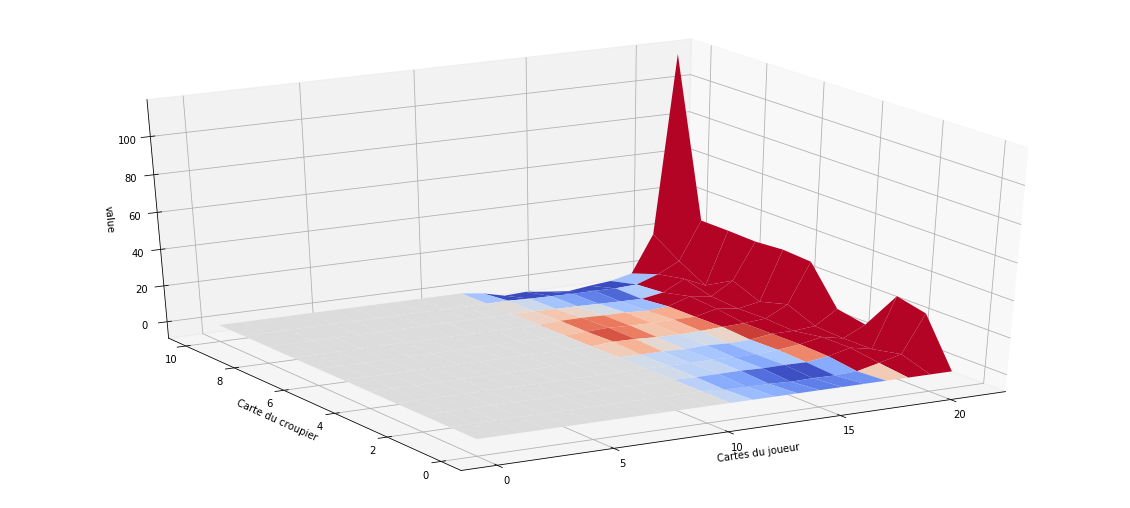

In [12]:
plot_values(V,True)

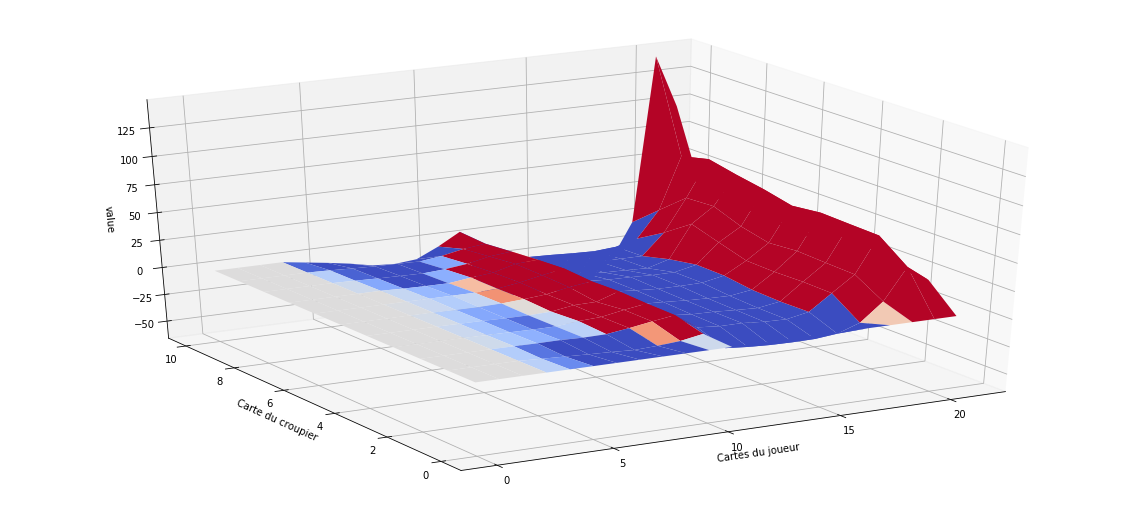

In [13]:
plot_values(V,False)

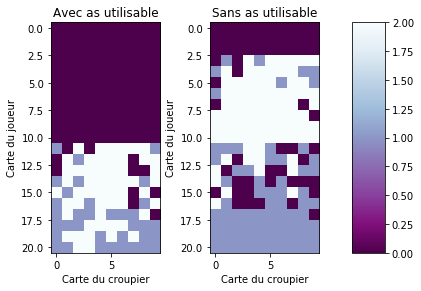

In [14]:
plot_policy(policy)

0 correspond à un état ou aucune action n'est définie, 1  correspond à l'action "s'arréter" et 2 à l'action "demander une carte".

In [15]:
defeat,nul,victory=playGames(10000,policy)
print('Pourcentage de victoire',victory/100)
print('Pourcentage de défaite',defeat/100)
print("Pourcentage d'égalité",nul/100)

Pourcentage de victoire 40.53
Pourcentage de défaite 44.91
Pourcentage d'égalité 14.56


## SARSA

In [16]:
def update_Q_sarsa(alpha, gamma, Q, state, action, reward, next_state=None, next_action=None):
    if next_state==None:
            Q[state][action]=Q[state][action]+alpha*(reward-Q[state][action])
    else:
        Q[state][action]=Q[state][action]+alpha*(reward+gamma*Q[next_state][next_action]-Q[state][action])
    return Q
    
def epsilon_greedy(Q, state, nA, eps):
    # Complete
    if np.random.rand() < eps:
        action = np.argmax(Q[state])
    else:
        action = np.random.randint(0, nA)
    return action

In [17]:
def sarsa(env, num_episodes, alpha, gamma=1.0, epsmin=0.01):
    # Complete
    action_space_size=2
    policy = {}
    env_state_space_size1=10
    env_state_space_size2=10
    env_state_space_size3=2
    for i in range(1, 30):
        for j in range(1, env_state_space_size2+1):
            for k in range(2):
                if k==0:
                    key=(i,j,False)
                else:
                    key=(i,j,True)
                p = [0]*action_space_size
                for action in range(0, action_space_size):
                    p[action] = 1 /action_space_size
                policy[key] = p    
    Q = {}
    for key in policy.keys():
         #Q[key] = {a: 0.0 for a in range(0, env.action_space.n)}
        Q[key] =[0,0]
    epsilon=1
    eps_decay=.99999
    for i in range(num_episodes):
        total_reward = 0
        state = env.reset()
        n_actions=action_space_size
        action = epsilon_greedy(Q, state, n_actions, epsilon)
        done=False
        while not done:
            next_state, reward, done, info = env.step(action)
            if done:
                Q=update_Q_sarsa(alpha, gamma, Q, state, action, reward)
            else:
                next_action=epsilon_greedy(Q,next_state, n_actions,epsilon)
                Q=update_Q_sarsa(alpha, gamma, Q, state, action, reward,next_state,next_action)
                action, state= next_action,next_state
        if epsilon>epsmin:
            epsilon=epsilon*eps_decay
        
    return Q

In [18]:
# Compute  the optimal policy and value function
Q_sarsa = sarsa(env, 500000, 0.009)
Vsarsa = dict((k,np.max(v)) for k, v in Q_sarsa.items())

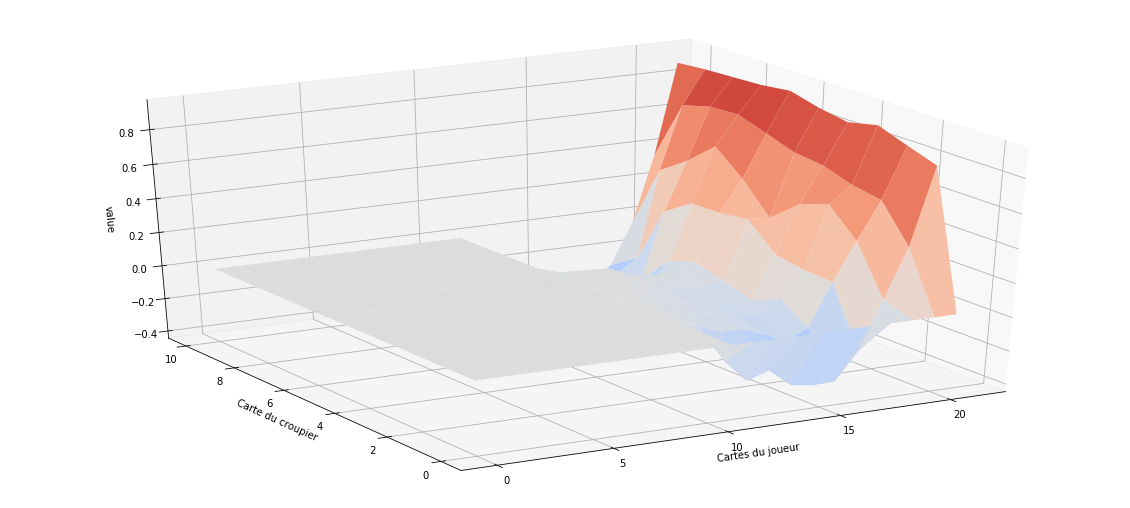

In [19]:
plot_values(Vsarsa,True)

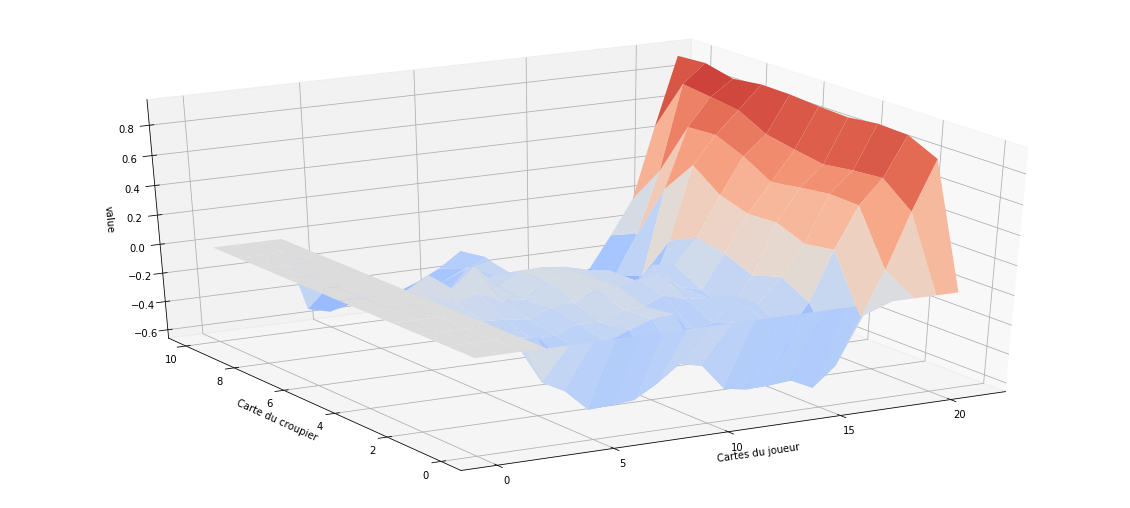

In [20]:
plot_values(Vsarsa,False)

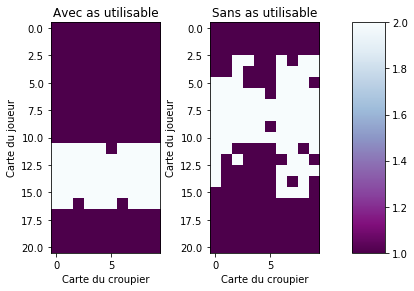

In [21]:
policy_sarsa = dict((k,np.argmax(v)) for k, v in Q_sarsa.items())
plot_policy(policy_sarsa)

In [22]:
defeat,nul,victory=playGames(10000,policy_sarsa)
print('Pourcentage de victoire',victory/100)
print('Pourcentage de défaite',defeat/100)
print("Pourcentage d'égalité",nul/100)

Pourcentage de victoire 43.24
Pourcentage de défaite 46.06
Pourcentage d'égalité 10.7


## Q-learning

In [23]:
def update_Q_sarsamax(alpha, gamma, Q, state, action, reward, next_state=None):
    # Complete
    if next_state==None:
        Q[state][action]=Q[state][action]+alpha*(reward-Q[state][action])
    else:
        if Q[next_state][0]>Q[next_state][1]:
            Q[state][action]=Q[state][action]+alpha*(reward+gamma*Q[next_state][0]-Q[state][action])
        else:
            Q[state][action]=Q[state][action]+alpha*(reward+gamma*Q[next_state][1]-Q[state][action])
        
    return Q

In [24]:
def q_learning(env, num_episodes, alpha, gamma=1.0,epsmin=0.01):
    # Complete
    action_space_size=2
    policy = {}
    env_state_space_size1=10
    env_state_space_size2=10
    env_state_space_size3=2
    for i in range(1, 30):
        for j in range(1, env_state_space_size2+1):
            for k in range(2):
                if k==0:
                    key=(i,j,False)
                else:
                    key=(i,j,True)
                p = [0]*action_space_size
                for action in range(0, action_space_size):
                    p[action] = 1 /action_space_size
                policy[key] = p    
    Q = {}
    for key in policy.keys():
         #Q[key] = {a: 0.0 for a in range(0, env.action_space.n)}
        Q[key] =[0,0]
    epsilon=1
    eps_decay=.99999
    for i in range(num_episodes):
        total_reward = 0
        state = env.reset()
        n_actions=action_space_size
        action = epsilon_greedy(Q, state, n_actions, epsilon)
        done=False
        while not done:
            next_state, reward, done, info = env.step(action)
            if done:
                Q=update_Q_sarsamax(alpha, gamma, Q, state, action, reward)
            else:
                Q=update_Q_sarsamax(alpha, gamma, Q, state, action, reward,next_state)
                next_action=epsilon_greedy(Q,next_state, n_actions,epsilon)
                action, state= next_action,next_state
        if epsilon>epsmin:
            epsilon=epsilon*eps_decay
    return Q

In [25]:
# Compute  the optimal policy and value function
Q_sarsamax = q_learning(env, 500000, 0.01)
Vsarsamax = dict((k,np.max(v)) for k, v in Q_sarsamax.items())


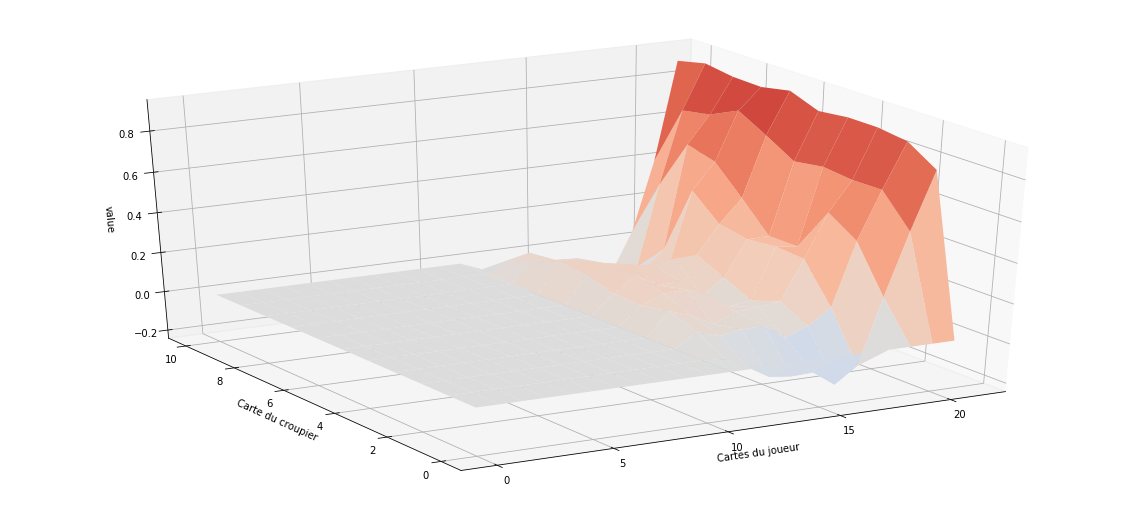

In [26]:
plot_values(Vsarsamax,True)

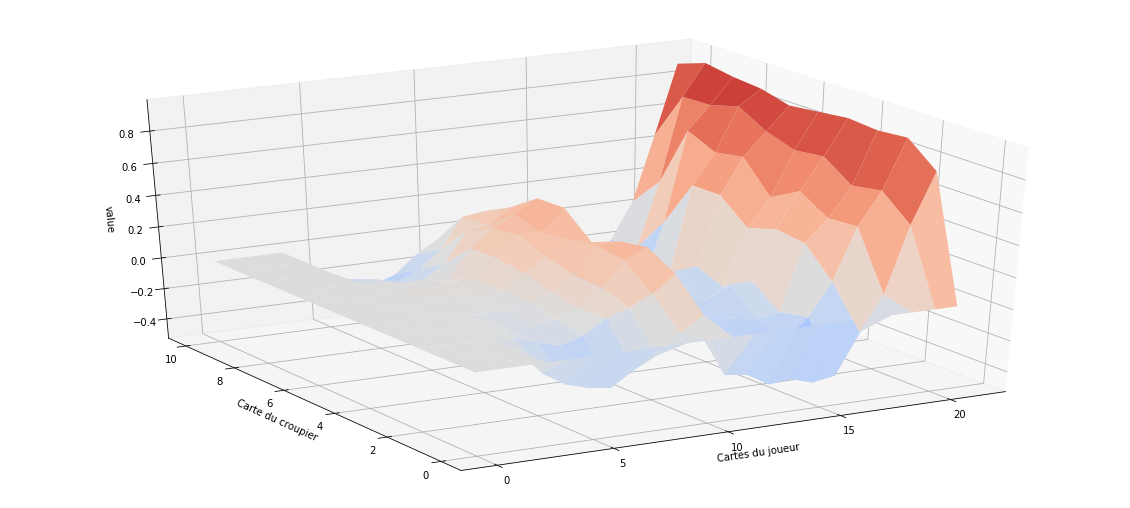

In [27]:
plot_values(Vsarsamax,False)

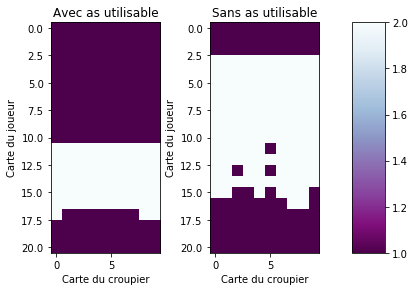

In [28]:
policy_sarsamax = dict((k,np.argmax(v)) for k, v in Q_sarsamax.items())
plot_policy(policy_sarsamax)

In [29]:
defeat,nul,victory=playGames(10000,policy_sarsamax)
print('Pourcentage de victoire',victory/100)
print('Pourcentage de défaite',defeat/100)
print("Pourcentage d'égalité",nul/100)

Pourcentage de victoire 41.81
Pourcentage de défaite 41.26
Pourcentage d'égalité 16.93
